# Practical Assignment 3

Recurrent neural networks can deal with sequential data (timeseries). In this assignment a recurrent neural network is implemented which computes the current outpus as the sum of the two previous inputs. 

First we deal with the imports:

In [1]:
from __future__ import division

import numpy as np
import chainer
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TupleDataset
import chainer.training as training
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from chainer import iterators
from chainer.cuda import to_cpu

### Implementation of RNN


In [2]:
class RNN(Chain):
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.lstm = L.LSTM(None,1) 
            self.linear = L.Linear(None,1)
                
    def reset_state(self):
        self.lstm.reset_state()

    def __call__(self, x):
        # Given the current input compute the sum
        h = self.lstm(x)
        y = self.linear(h)
        return y
                

class Regressor(Chain):
    """

    Regressor chain on top of Neural Network chain 
    for accuracy evaluation and prediction
 
    """
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        return loss

The next class shows the backprop through time method. This is the main training method.

In [6]:
class BPTTUpdater(chainer.training.StandardUpdater):

    def __init__(self, train_iter,  optimizer, bprop_len, rnn):
        super(BPTTUpdater, self).__init__(train_iter, optimizer)
        self.bprop_len = bprop_len

    # The core part of the update routine can be customized by overriding.
    def update_core(self):
        train_loss = []
        test_loss = []
        # When we pass one iterator and optimizer to StandardUpdater.__init__,
        # they are automatically named 'main'.
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        count = 0
        loss = 0
        # Progress the dataset iterator for bprop_len 
        for i in range(self.bprop_len):
            count += 1
            # Get the next batch 
            batch = train_iter.__next__()
            
            x, t = self.converter(batch)
            model.reset_state()
            # Compute the loss at this time step and accumulate it
            loss = optimizer.target(chainer.Variable(x), chainer.Variable(t))
            if count % 10 == 0:
                optimizer.target.cleargrads()  # Clear the parameter gradients
                loss.backward()  # Backprop
                loss.unchain_backward()
                optimizer.update()  # Update the parameters
                train_loss.append(loss)
                #calculate test loss
                test_batch = test_iter.next()
                xtest, ttest = self.converter(test_batch)
                # Forward the test data
                loss_test = regressor(xtest, ttest)
                test_loss.append(loss_test)
        return train_loss, test_loss

Datacreator method, as given in the course.

In [7]:
def create_data(n=3000):
    X = np.random.rand(n, 1).astype('float32')
    T = np.sum(np.hstack((X[0:-1], X[1:])), axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n, 1])

    return TupleDataset(X, T)

The training loop has a sequence of 100 inputs which is run through the recurrent network for 1 epoch.

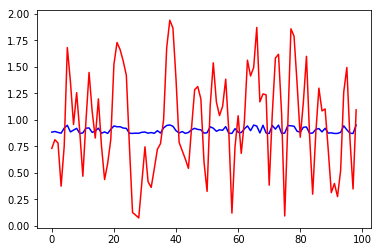

In [8]:
#retrieve the data
train_data = create_data()
test_data = create_data()
inputs, labels = np.array([tup[0] for tup in test_data]), np.array([tup[1] for tup in test_data])

#instantiating iterators
train_iter = iterators.SerialIterator(train_data, 1)
test_iter = iterators.SerialIterator(test_data, 1,repeat=False, shuffle=False)

#instantiating a model
model = RNN()
regressor = Regressor(model)

#choosing an optimizer
optimizer = chainer.optimizers.SGD(lr=0.05)
optimizer.setup(regressor)
updater = BPTTUpdater(train_iter, optimizer,3000, model)

#update network (evaluation is done within the loop)
train_loss, test_loss = updater.update_core()
model.reset_state()

#visualize_loss(train_loss, test_loss, nr_epochs=1)
new_inputs = inputs[1:100]
pred_inputs = model(new_inputs).data
actual_inputs = labels[1:100]
plt.plot(pred_inputs, 'b')
plt.plot(actual_inputs, 'r')


### Test vs. Trainings Loss

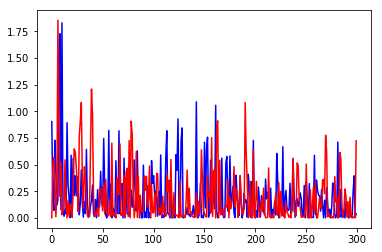

In [9]:
plt1 = [x.data.item() for x in train_loss]
plt2 = [x.data.item() for x in test_loss]
plt.plot(plt1, 'b')
plt.plot(plt2, 'r')